In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [117]:
def torch_randnorm(size, dim=0):
    # Generate a random tensor
    rand_tensor = torch.rand(size)
    
    # Normalize along the specified dimension
    sum_along_dim = torch.sum(rand_tensor, dim=dim, keepdim=True)
    normalized_tensor = rand_tensor / sum_along_dim
    
    return normalized_tensor

# Example usage
normalized_tensor = torch_randnorm([5,6], dim=1)
print(normalized_tensor)
print(normalized_tensor.sum(dim=1))

tensor([[0.0525, 0.1113, 0.1690, 0.3038, 0.0524, 0.3110],
        [0.1465, 0.2088, 0.2863, 0.0633, 0.1524, 0.1427],
        [0.1088, 0.2824, 0.2392, 0.1301, 0.1327, 0.1068],
        [0.2387, 0.2297, 0.2191, 0.1337, 0.0728, 0.1060],
        [0.1171, 0.1673, 0.0696, 0.1750, 0.4067, 0.0643]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [118]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.attention_weights = nn.Linear(n_features, 1, bias=False)
        self.interaction_tensors = nn.Parameter(torch.randn(n_features, n_features, n_features, n_features + 1))
        self.topk_num = 1
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Establish normalized subgroups
        norm_subgroups = torch.cat((state_tensor.unsqueeze(-2), previous_transition_tensor), dim=1)
        batch_size, num_groups, n_features = norm_subgroups.shape
        
        # Compute scores for each normalized subgroup
        scores = self.attention_weights(norm_subgroups).sum(-1) # [batch_size, num_groups]
        
        weights = torch.softmax(scores,dim = -1) # [batch_size, num_groups]
        
        selected_interaction_tensors = self.interaction_tensors
        selected_norm_subgroups = norm_subgroups

        selected_transition_tensors = torch.einsum('ijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
        
        # Generate state tensors from the interaction tensor
        
        new_state_tensors = torch.einsum('bjks,bj->bks',selected_transition_tensors, state_tensor)
        
        # Sum into a new state tensor
        new_state_tensor = torch.einsum('bs,bks->bk',weights,new_state_tensors)
        
        softmax_tensor = torch.softmax(new_state_tensor * n_features, dim = 1)
        
        # We need a single transition tensor so we will average this as well
        selected_transition_tensor = torch.einsum('bs,bjks->bjk',weights,selected_transition_tensors)
        
        return softmax_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = torch.zeros(batch, n_features, n_features)

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


# Sequence-to-Sequence Check

In [119]:
n_features = 16
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)
y = model(x)

print(y[0].shape)
assert y[0].shape == x.shape

torch.Size([13, 64, 16])


## Consistency Check

In [120]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch.randn(batch, n_features, n_features)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([ 0.5302, -1.1590,  0.2369, -0.7794])
tensor([9.6388e-05, 3.9877e-05, 9.9986e-01, 1.3580e-08],
       grad_fn=<SliceBackward0>)
tensor([9.6388e-05, 3.9877e-05, 9.9986e-01, 1.3580e-08],
       grad_fn=<SliceBackward0>)


This should be the same as if we just look at the batches independently

In [121]:
batch = 2
transition_tensor = transition_tensor[0:2,:,:]
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([9.6388e-05, 3.9877e-05, 9.9986e-01, 1.3580e-08],
       grad_fn=<SliceBackward0>)

In [122]:
states = []
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

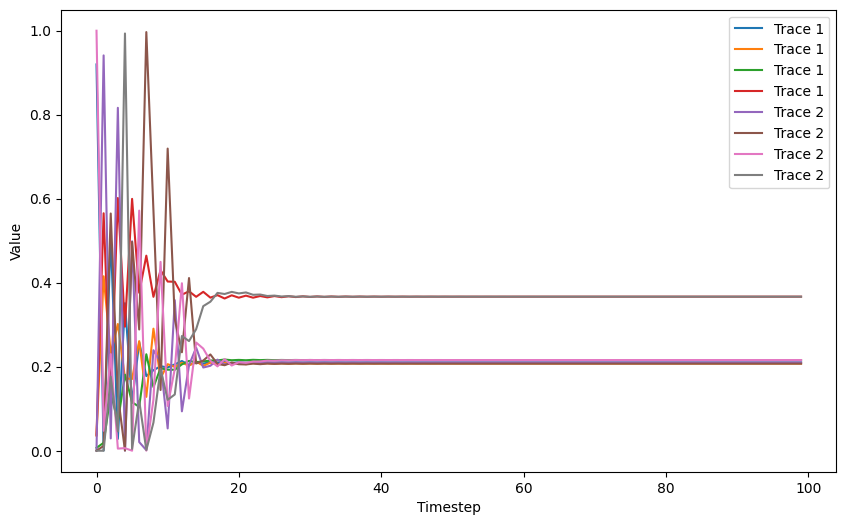

In [123]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

# Example Training

## Simple Data Generation

In [124]:
import numpy as np
import torch

def generate_normalized_multivariate_time_series(n_features, total_length, amplitude=1.0):
    t = np.linspace(0, 100 * np.pi, total_length)
    series = np.zeros((total_length, n_features))
    for i in range(n_features):
        series[:, i] = amplitude * np.cos(t * (i + 1) / n_features) + 10
    
    # Normalize such that each timestep's values sum to 1
    series_sum = np.sum(series, axis=1, keepdims=True)
    series_normalized = series / series_sum
    
    return series_normalized

def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)


In [125]:
n_features = 4
length = 64  # Segment length
total_length = 1024  # Arbitrary total length for the generated series

# Generate and segment the time series
series = generate_normalized_multivariate_time_series(n_features, total_length)
series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y


In [126]:
from torch import nn, optim

# Model
model = NeuralCoilLayer(
    n_features = n_features
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [10/1000], Loss: 0.003100151428952813
Epoch [20/1000], Loss: 0.0011635853443294764
Epoch [30/1000], Loss: 0.0004045783425681293
Epoch [40/1000], Loss: 0.00025569129502400756
Epoch [50/1000], Loss: 0.00025265381555072963
Epoch [60/1000], Loss: 0.00024382189440075308
Epoch [70/1000], Loss: 0.00023713659902568907
Epoch [80/1000], Loss: 0.0002338692866032943
Epoch [90/1000], Loss: 0.00023048694129101932
Epoch [100/1000], Loss: 0.0002271439734613523
Epoch [110/1000], Loss: 0.00022391679522115737
Epoch [120/1000], Loss: 0.0002205925266025588
Epoch [130/1000], Loss: 0.00021716667106375098
Epoch [140/1000], Loss: 0.00021367678709793836
Epoch [150/1000], Loss: 0.00021016890241298825
Epoch [160/1000], Loss: 0.00020673073595389724
Epoch [170/1000], Loss: 0.0002034926146734506
Epoch [180/1000], Loss: 0.0002005891437875107
Epoch [190/1000], Loss: 0.00019797991262748837
Epoch [200/1000], Loss: 0.00019553689344320446
Epoch [210/1000], Loss: 0.000193168903933838
Epoch [220/1000], Loss: 0.0001907

In [127]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs, Y, batch_index=3, feature_index=3)


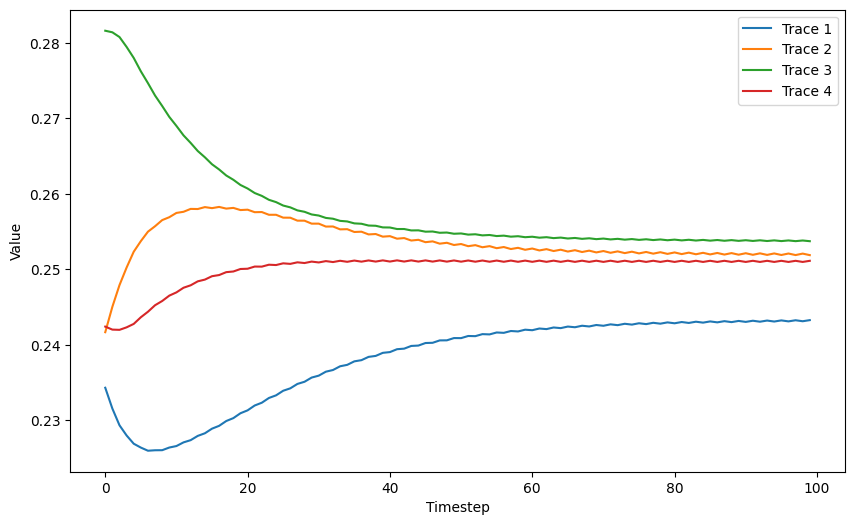

In [128]:
states = []
batch = 5
state_tensor = outputs[:,length-1,:]
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()